In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary

In [2]:
training = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
testing = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64
train_dataloader = DataLoader(training, batch_size=batch_size)
test_dataloader = DataLoader(testing, batch_size=batch_size)

In [4]:
class Classifier(nn.Module):
    def __init__(self): #28x28
        super().__init__()
        self.conv1 = nn.Conv2d(1,20,(5,5)) #20x24x24
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2,2)) #20x12x12
        
        self.conv2 = nn.Conv2d(20,50,(5,5)) #50x8x8
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2,2)) #50x4x4
        
        self.fc1 = nn.Linear(800,500) #500
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(500,10) #10
        self.softmax = nn.LogSoftmax(1)
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self): #28x28
        super().__init__()
        self.maxpool = nn.MaxPool2d((2,2)) #14x14
        self.encoding = nn.Parameter(torch.rand((196)))
        encoder_layers = nn.TransformerEncoderLayer(196,4)
        self.encoder = nn.TransformerEncoder(encoder_layers,1)
        self.fc = nn.Linear(196,10)
        self.softmax = nn.LogSoftmax(1)
    def forward(self,x):
        x = torch.flatten(self.maxpool(x), 1) + self.encoding
        x = self.softmax(self.fc(self.encoder(x)))
        return x

In [6]:
model = VisionTransformer()

print(summary(model, input_size=(batch_size,1,28,28)))

loss = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

train_steps = len(train_dataloader.dataset) // batch_size
test_steps = len(test_dataloader.dataset) // batch_size

epochs = 10
for epoch in range(epochs):
    model.train()
    
    t_loss = 0
    v_loss = 0
    t_correct = 0
    v_correct = 0
    
    for (x,y) in train_dataloader:
        prediction = model(x)
        l = loss(prediction,y) + 0.01 * sum([torch.linalg.norm(p,1) for p in model.parameters()]) #L1 regularization
        
        opt.zero_grad()
        l.backward()
        opt.step()
        
        t_loss += l
        t_correct += (prediction.argmax(1) == y).type(torch.int).sum().item()
    
    with torch.no_grad():
        model.eval()
        
        for (x,y) in test_dataloader:
            prediction = model(x)
            l = loss(prediction,y)
            
            v_loss += l
            v_correct += (prediction.argmax(1) == y).type(torch.int).sum().item()
    print(f'Epoch {epoch+1}/{epochs}: tl-{t_loss/train_steps} tc-{t_correct/len(train_dataloader.dataset)} vl-{v_loss/test_steps} vc-{v_correct/len(test_dataloader.dataset)}')

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [64, 10]                  196
├─MaxPool2d: 1-1                              [64, 1, 14, 14]           --
├─TransformerEncoder: 1-2                     [64, 196]                 --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 196]                 960,292
├─Linear: 1-3                                 [64, 10]                  1,970
├─LogSoftmax: 1-4                             [64, 10]                  --
Total params: 962,458
Trainable params: 962,458
Non-trainable params: 0
Total mult-adds (M): 51.70
Input size (MB): 0.20
Forward/backward pass size (MB): 1.35
Params size (MB): 3.23
Estimated Total Size (MB): 4.79
Epoch 1/10: tl-6.367188930511475 tc-0.87305 vl-0.22889652848243713 vc-0.9323
Epoch 2/10: tl-5.374226093292236 tc-0.9385333333333333 vl-0.16316552460193634 vc-0.9512
Epoch 3

7
2
1
0
4
1
4
9
5
9
0
6
9
0
1
5
9
7
3
4
9
6
6
5
4


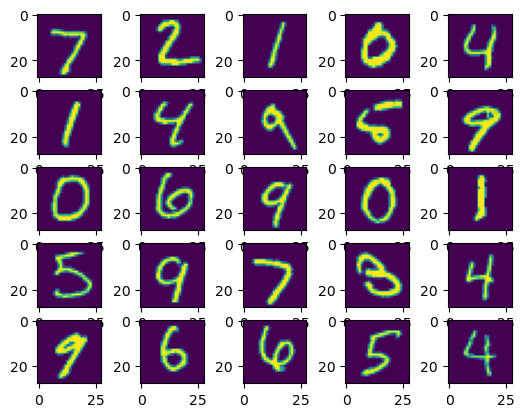

In [7]:
import matplotlib.pyplot as plt
dim = (5,5)
_, ax = plt.subplots(*dim)
for i in range(dim[0]*dim[1]):
    ax[i//dim[0]][i%dim[0]].imshow(test_dataloader.dataset[i][0][0])
    print(test_dataloader.dataset[i][1])